In [19]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [20]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [21]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [22]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [23]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [24]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [25]:
volume = Volume(get_layers())

# VolumeWrapper

In [26]:
from functools import partial

In [27]:
volume = Volume(get_layers())

In [28]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e9), eff_opt=partial(torch.optim.SGD, lr=2e2),
                        loss_func=DetectorLoss(0))

In [29]:
from tomopt.optimisation import MetricLogger

In [30]:
ml = MetricLogger(show_plots=True)

In [31]:
trn_passives = PassiveYielder([arb_rad_length])

In [32]:
from tomopt.optimisation.callbacks.callback import Callback

In [33]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

In [34]:
x = Tensor([0,1,2,3])
x

tensor([0., 1., 2., 3.])

In [35]:
torch.cat([x,x], dim=0)

tensor([0., 1., 2., 3., 0., 1., 2., 3.])

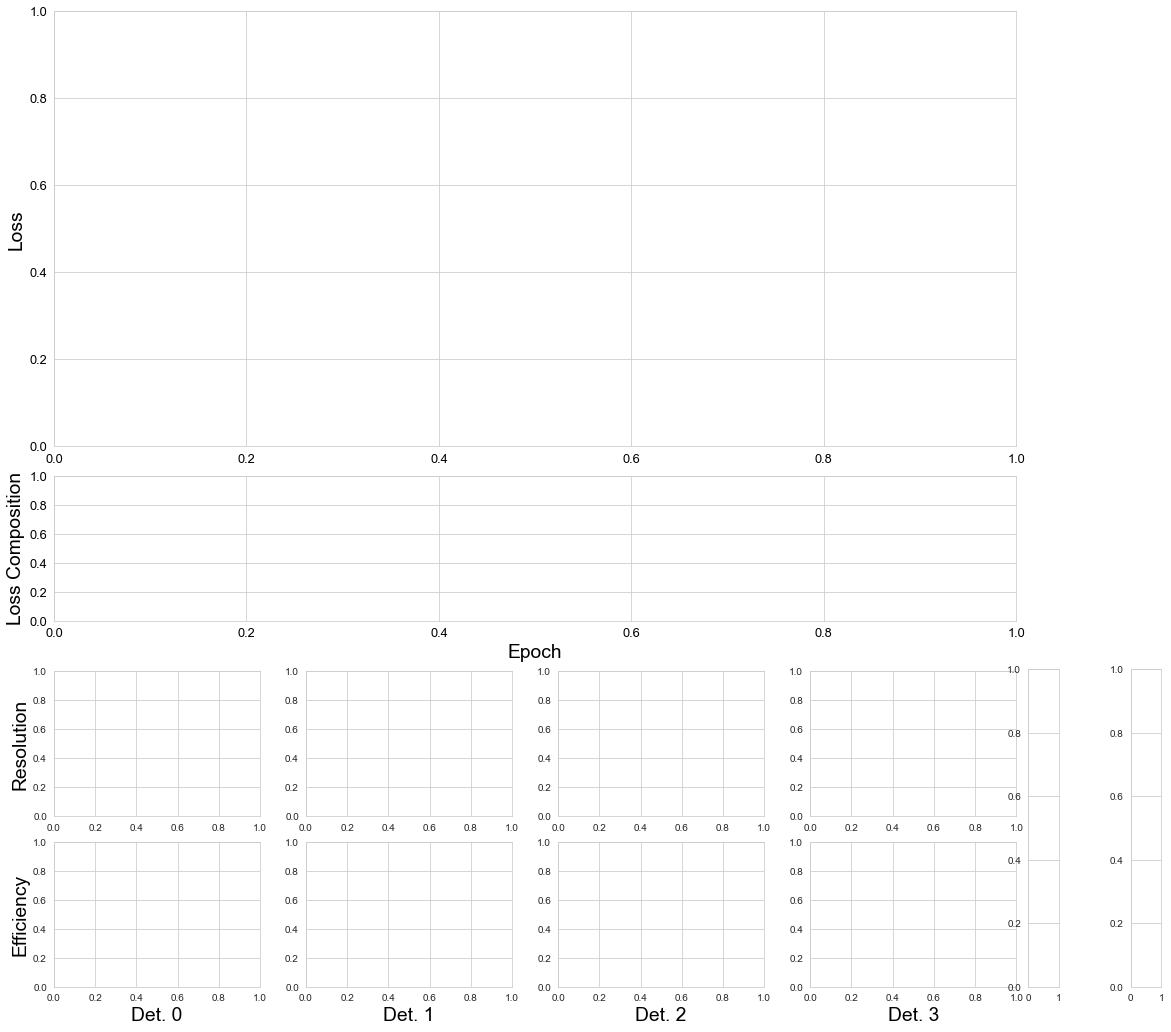

theta x tensor([-0.0203,  0.1487,  0.0686,  0.0190, -0.0051,  0.0028,  0.0258,  0.0133,
         0.0056, -0.0064])
theta y tensor([ 0.0429,  0.0504,  0.0254, -0.0162, -0.1984,  0.0165,  0.0485,  0.0334,
        -0.0106,  0.0386])
x tensor([0.2871, 0.5461, 0.3641, 0.8140, 0.2961, 0.2638, 0.7141, 0.8633, 0.4302,
        0.2733])
y tensor([ 0.2757,  0.6139,  0.8673,  0.6123, -0.1344,  0.1539,  0.2222,  0.7358,
         0.5092,  0.9956])
scatter dloc/dres tensor([[-2.0043e-06,  3.2972e-06, -8.8009e-05],
        [-2.5626e-05, -8.5548e-06,  1.6372e-04],
        [ 7.4286e-06,  6.1116e-06, -1.5563e-04],
        [-1.2343e-06, -4.0960e-06, -1.3438e-04],
        [-8.8123e-08, -1.6184e-06,  7.3781e-05],
        [ 5.8188e-06,  5.3368e-06, -1.5307e-04],
        [ 9.2813e-07,  1.6739e-06, -3.6400e-05],
        [ 9.9787e-07,  1.1691e-06, -7.0105e-05],
        [-3.6963e-06,  8.6287e-06, -2.2116e-04],
        [ 1.1355e-05, -4.1898e-05, -4.4063e-04]], grad_fn=<SliceBackward>)
scatter dlocunc/dres tensor(

theta x tensor([ 0.0062, -0.1465,  0.2036, -0.1302,  0.0420,  0.1395, -0.1141,  0.0745,
        -0.1087,  0.0135])
theta y tensor([ 0.0303,  0.0390,  0.0335,  0.0082, -0.1742, -0.2155,  0.0385,  0.0882,
        -0.0587,  0.0450])
x tensor([0.4200, 0.5942, 0.6350, 0.6315, 0.7493, 1.0730, 0.6334, 0.1862, 0.3827,
        0.0290])
y tensor([ 0.1324,  0.2362,  0.8283,  0.6064,  0.6679, -0.1214,  0.4627,  0.4594,
         0.0096,  0.7632])
scatter dloc/dres tensor([[ 3.6971e-07,  1.1668e-06, -3.4314e-05],
        [ 1.2985e-05, -5.8694e-06,  1.3763e-04],
        [ 7.0300e-06,  5.0590e-07, -2.3757e-05],
        [ 4.4400e-06, -6.1129e-07,  2.6680e-05],
        [-7.9883e-06,  3.0059e-05,  1.7991e-04],
        [-6.6662e-06,  1.9628e-06, -5.4798e-05],
        [ 1.1126e-05,  1.2822e-05, -1.5442e-04],
        [-7.7903e-05, -4.6851e-05, -7.2816e-04],
        [-2.3622e-06,  4.9598e-06, -1.2908e-04],
        [ 7.0791e-06, -7.8803e-06, -3.6554e-04]], grad_fn=<SliceBackward>)
scatter dlocunc/dres tensor(

scatter ddtheta/dres tensor([[-1.8094e-07, -9.9041e-06],
        [-5.7699e-06, -6.7835e-06],
        [-1.0176e-05, -6.7048e-06],
        [-1.2086e-05, -1.0398e-05],
        [-1.1661e-05,  1.1450e-05],
        [ 5.5939e-06, -3.0586e-06],
        [-6.2499e-06, -9.7268e-06],
        [-4.1014e-06, -7.4777e-06],
        [ 2.5480e-06,  9.1876e-06],
        [ 3.4378e-06, -7.5298e-06]], grad_fn=<SliceBackward>)
scatter ddthetaunc/dres tensor([[1.5699e-09, 4.9662e-06],
        [2.1177e-06, 2.1463e-06],
        [5.6816e-06, 3.7379e-06],
        [7.3148e-06, 6.7778e-06],
        [4.5067e-06, 4.8997e-06],
        [1.2599e-06, 5.0752e-07],
        [3.6394e-06, 4.3305e-06],
        [8.0176e-07, 4.6809e-06],
        [3.3508e-07, 4.3108e-06],
        [7.3518e-07, 3.6685e-06]], grad_fn=<SliceBackward>)
scatter ddxy/dres tensor([[ 5.8373e-07, -2.8495e-07],
        [-1.1935e-06, -5.6863e-07],
        [-2.8720e-06, -8.0178e-07],
        [ 1.5471e-06, -2.0354e-06],
        [ 5.3473e-06,  5.4726e-06],
     

KeyboardInterrupt: 

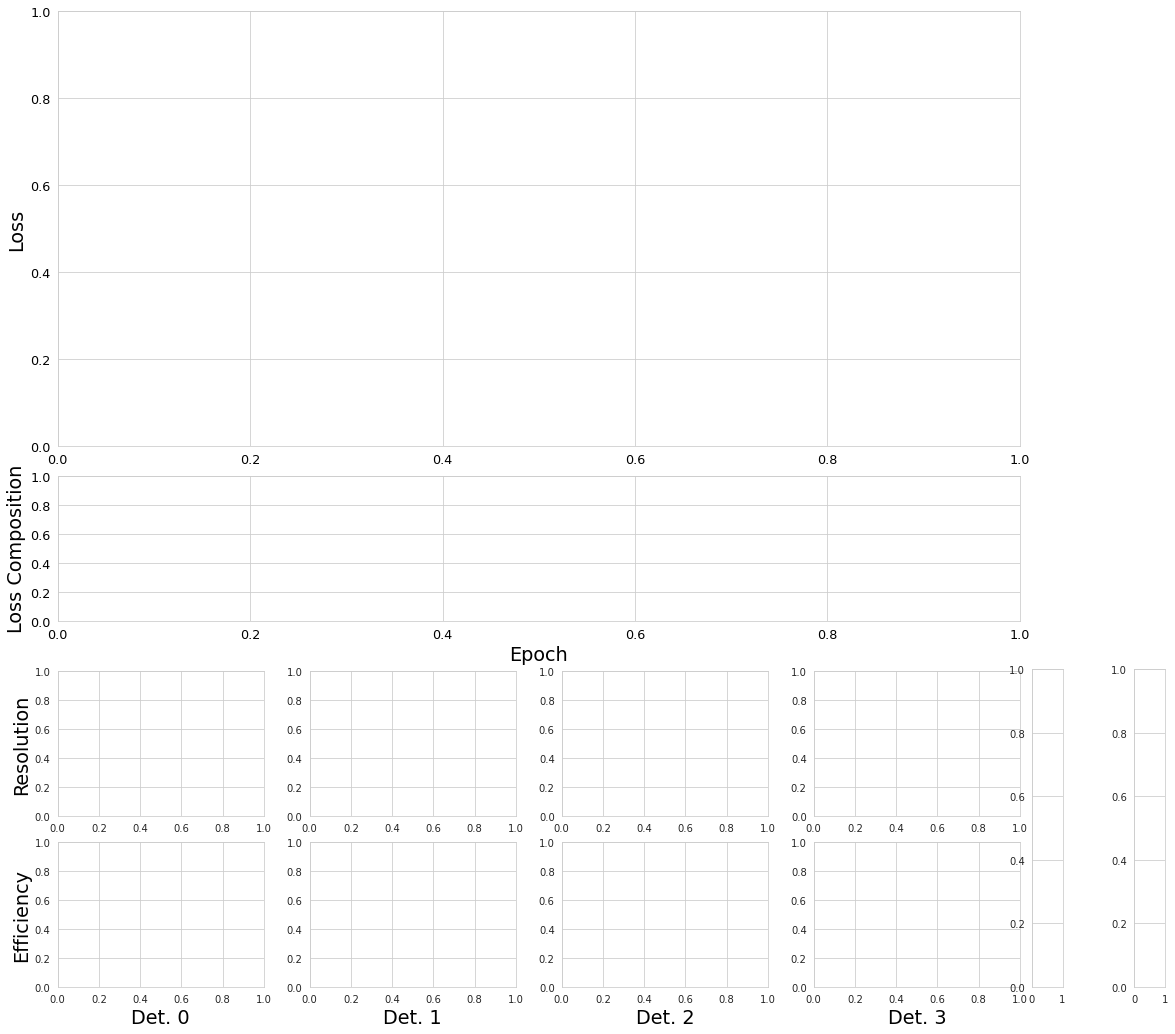

In [37]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ml])

In [19]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)

1 Parameter containing:
tensor([[1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
        [1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.]],
       requires_grad=True) Parameter containing:
tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.5000, 0.5000, 0.